In [131]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid, cumulative_trapezoid
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapezoid
import paths
from matplotlib import colors
import tqdm
import utils
import paths
import cmasher as cmr

In [132]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = True
fs = 12


# update various fontsizes to match
params = {'figure.figsize': (6,4),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)


# set up the LISA frequency grid
f_LISA = np.logspace(-1, -5, 150) * u.Hz

# set up the LIGO eccentricity range
e_LIGO = np.logspace(-6, np.log10(0.001), 20)
e_LIGO = np.append(0, e_LIGO)
e_LIGO_round = np.array([f"{e:.2e}" for e in e_LIGO])


# get the mass, mass ratio, and rate grids
down_samp_fac_q=30
down_samp_fac_m1=15
mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = utils.get_LIGO_rate(down_samp_fac_m1=down_samp_fac_m1, down_samp_fac_q=down_samp_fac_q)

MM, QQ, EE_LIGO, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO, f_LISA, indexing='ij')


In [133]:
EE_LISA = np.load(paths.data / 'e_LISA_run2.npy')
TT_LISA = np.load(paths.data / 't_merge_run2.npy') * u.Gyr
VC = np.load(paths.data / 'comoving_volume_run2.npy') * u.Gpc**3
DH = np.load(paths.data / 'horizon_distance_run2.npy') * u.Gpc 

In [134]:
np.shape(dN_dm1dqdVcdt), np.shape(mass_1)

((17, 67), (67,))

In [135]:
def get_VC_new(snr_thresh_new, DH, VC):
    snr_thresh_data = 12
    DH = DH * snr_thresh_data / snr_thresh_new
    VC = 4/3 * np.pi * DH**3

    return VC

In [136]:
dT_LIGO_df_LISA = utils.dTmerger_df(MM, QQ*MM, FF, EE_LISA).to(u.yr / u.Hz)

In [137]:
np.shape(dT_LIGO_df_LISA), np.shape(dN_dm1dqdVcdt)

((67, 17, 21, 150), (17, 67))

In [138]:
cs = cmr.take_cmap_colors('cmr.sapphire', len(mass_1), cmap_range=(0.15, 0.6), return_fmt='hex')
cs2 = cmr.take_cmap_colors('cmr.emerald', 3, cmap_range=(0.15, 0.9), return_fmt='hex')
ecc_ind = 0
q_ind = 16
ind_m_10 = 3
ind_m_35 = 14
ind_m_80 = 32

In [139]:
dn_LISA = np.zeros((len(mass_1), len(f_LISA)))
for ff, forb in enumerate(f_LISA):
    dn_LISA[:,ff] = trapezoid(dT_LIGO_df_LISA[:,:,ecc_ind,ff] * dN_dm1dqdVcdt[:, :].T, mass_ratio).to(1/u.Hz / u.Msun / u.Gpc**3)

dN_dm1_list = []
for snr_thresh in [1,7,12]:
    VC_new = get_VC_new(snr_thresh, DH, VC)
    dN_dm1 = np.zeros(len(mass_1)) / u.Msun
    for ii, m in enumerate(mass_1):
        dN_dm1dq = np.zeros(len(mass_ratio)) / u.Msun
        for jj, q in enumerate(mass_ratio):
            dN_dm1dq[jj] = trapezoid(dN_dm1dqdVcdt[jj,ii] * -dT_LIGO_df_LISA[ii,jj,ecc_ind,:]* VC_new[ii,jj,ecc_ind,:], f_LISA).to(1/u.Msun)
        dN_dm1[ii] = trapezoid(dN_dm1dq, mass_ratio)
        
    dN_LISA_obs = np.zeros((len(mass_1), len(f_LISA)))
    
    dN_LISA_obs[:,ff] = trapezoid(dT_LIGO_df_LISA[:,:,ecc_ind,ff] * dN_dm1dqdVcdt[:, :].T * VC_new[:,:,ecc_ind,ff], mass_ratio).to(1/u.Hz / u.Msun)
    dN_LISA_obs = dN_LISA_obs * u.s / u.Msun
    dN_dm1_list.append(dN_dm1)


In [140]:
dn_LISA = dn_LISA * u.s / u.Msun / u.Gpc**3


In [141]:
dn_dm1 = trapezoid(f_LISA, dn_LISA).to(1/u.Msun / u.Gpc**3)
dn_dm1[0] = 1e-19 / u.Msun / u.Gpc**3

In [142]:
labels = [r'$M_1=10\,M_{\odot}$', r'$M_1=35\,M_{\odot}$', r'$M_1=80\,M_{\odot}$']
labels_snr = [r'$SNR > 1$', r'$SNR > 7$', r'$SNR > 12$']

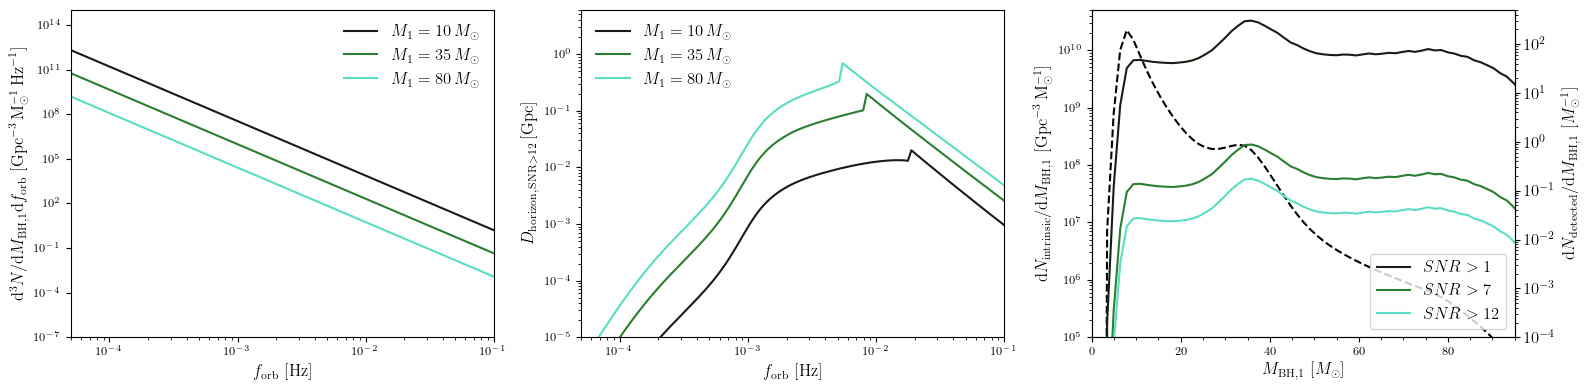

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
#p = ax1.scatter(FF[:,q_ind,ecc_ind,:], MM[:,q_ind,ecc_ind,:], c=dn_LISA.value, norm=colors.LogNorm(vmax=1e14), s=14, marker='o')
for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    ax1.plot(FF[ind,q_ind,ecc_ind,:], dn_LISA.value[ind,:], color=cs2[ii], label=labels[ii])
ax1.set_xscale('log')
#cbar = plt.colorbar(p)
#cbar.set_label(label=r'$\mathrm{d}^3N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]')

ax1.set_xlabel(r'$f_{\rm orb}$ [Hz]')
ax1.set_ylabel(r'$\mathrm{d}^3N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 0.1)
ax1.set_ylim(1e-7, 1e15)
ax1.legend(frameon=False)
ax1.minorticks_on()

for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    ax2.plot(f_LISA, DH[ind, q_ind, ecc_ind, :], color=cs2[ii], label=labels[ii])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(frameon=False)
ax2.set_ylabel(r'$D_{\rm{horizon,\,SNR>12}}\,[\rm{Gpc}]$')
ax2.set_xlabel(r'$f_{\rm orb}$ [Hz]')
ax2.set_ylim(1e-5, 6)
ax2.set_xlim(5e-5, 0.1)

ax3.plot(mass_1.value, dn_dm1.value, ls='--', color='black')
ax3.set_yscale('log')
ax3.set_ylim(1e5, 5e10)
ax3.minorticks_on()
ax3.set_ylabel(r'$\mathrm{d}N_{\rm{intrinsic}} / \mathrm{d}M_{\mathrm{BH,1}}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}$]')
ax3.set_xlabel(r'$M_{\mathrm{BH,1}}$ [$M_{\odot}$]')

ax4 = ax3.twinx()

# Plot data on the second y-axis
color = 'navy'
ax4.set_ylabel(r'$\mathrm{d}N_{\rm{detected}} / \mathrm{d}M_{\mathrm{BH,1}}$ $[M_{\odot}^{-1}$]')
for ii, dNdm1 in enumerate(dN_dm1_list):
    ax4.plot(mass_1, dNdm1, color=cs2[ii], label=labels_snr[ii])
ax4.set_ylim(1e-4, 500)
ax4.set_xlim(0, 95)
ax4.set_yscale('log')
ax4.legend(loc='lower right')
ax4.tick_params(axis='y', labelsize=12)
fig.tight_layout()

In [144]:
for ii, dNdm1 in enumerate(dN_dm1_list):
    print(trapezoid(dNdm1, mass_1))

7529.500720577171
21.951897144539856
4.357349954037716


In [145]:
print(np.shape(mass_ratio), np.shape(dN_dm1dqdVcdt))
dN_dm1dVcdt = trapezoid(dN_dm1dqdVcdt, mass_ratio, axis=0)

(17,) (17, 67)


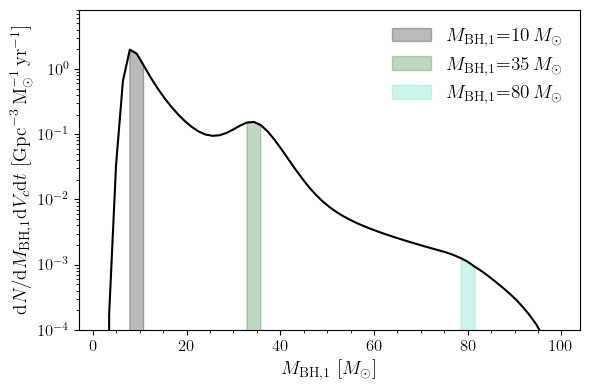

In [146]:
plt.plot(mass_1.value, dN_dm1dVcdt.value, ls='-', color='black')
plt.fill_between(mass_1.value[4:7], np.ones(len(mass_1.value[4:7]))*1e-7, dN_dm1dVcdt.value[4:7], color=cs2[0], alpha=0.3, label='$M_{\mathrm{BH,1}}$=10\,$M_{\odot}$')
plt.fill_between(mass_1.value[21:24], np.ones(len(mass_1.value[21:24]))*1e-7, dN_dm1dVcdt.value[21:24], color=cs2[1], alpha=0.3, label='$M_{\mathrm{BH,1}}$=35\,$M_{\odot}$')
plt.fill_between(mass_1.value[52:55], np.ones(len(mass_1.value[52:55]))*1e-7, dN_dm1dVcdt.value[52:55], color=cs2[2], alpha=0.3, label='$M_{\mathrm{BH,1}}$=80\,$M_{\odot}$')

plt.yscale('log')
plt.ylim(1e-4, 8)
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=12)
plt.ylabel(r'$\mathrm{d}N/ \mathrm{d}M_{\mathrm{BH,1}}\mathrm{d}V_c\mathrm{d}t$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{yr}^{-1}$]', size=14)
plt.xlabel(r'$M_{\mathrm{BH,1}}$ [$M_{\odot}$]', size=14)
plt.legend(prop={'size':14}, frameon=False)
plt.tight_layout()
plt.savefig('LIGO_rates.png', facecolor='white', dpi=250)

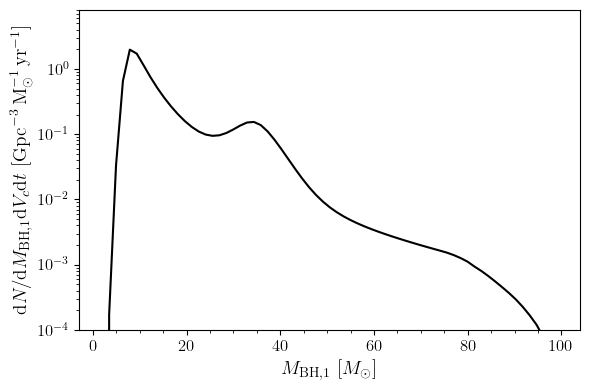

In [147]:
plt.plot(mass_1.value, dN_dm1dVcdt.value, ls='-', color='black')
#plt.fill_between(mass_1.value[4:7], np.ones(len(mass_1.value[4:7]))*1e-7, dN_dm1dVcdt.value[4:7], color=cs2[0], alpha=0.3, label='$M_{\mathrm{BH,1}}$=10\,$M_{\odot}$')
#plt.fill_between(mass_1.value[21:24], np.ones(len(mass_1.value[21:24]))*1e-7, dN_dm1dVcdt.value[21:24], color=cs2[1], alpha=0.3, label='$M_{\mathrm{BH,1}}$=35\,$M_{\odot}$')
#plt.fill_between(mass_1.value[52:55], np.ones(len(mass_1.value[52:55]))*1e-7, dN_dm1dVcdt.value[52:55], color=cs2[2], alpha=0.3, label='$M_{\mathrm{BH,1}}$=80\,$M_{\odot}$')

plt.yscale('log')
plt.ylim(1e-4, 8)
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=12)
plt.ylabel(r'$\mathrm{d}N/ \mathrm{d}M_{\mathrm{BH,1}}\mathrm{d}V_c\mathrm{d}t$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{yr}^{-1}$]', size=14)
plt.xlabel(r'$M_{\mathrm{BH,1}}$ [$M_{\odot}$]', size=14)
#plt.legend(prop={'size':14}, frameon=False)
plt.tight_layout()
plt.savefig('LIGO_rates.png', facecolor='white', dpi=250)

In [61]:
cs2

['#151E12', '#2B7D32', '#59DDC3']

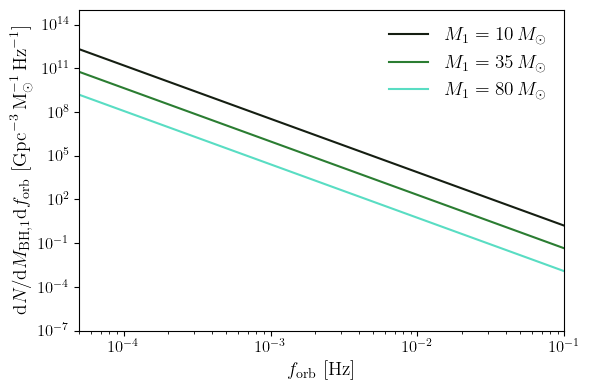

In [120]:
for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    plt.plot(FF[ind,q_ind,ecc_ind,:], dn_LISA.value[ind,:], color=cs2[ii], label=labels[ii])
plt.xscale('log')
#cbar = plt.colorbar(p)
#cbar.set_label(label=r'$\mathrm{d}^3N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]')

plt.xlabel(r'$f_{\rm orb}$ [Hz]', size=14)
plt.ylabel(r'$\mathrm{d}N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]', size=14)
plt.yscale('log')
plt.xlim(5e-5, 0.1)
plt.ylim(1e-7, 1e15)
plt.tick_params(axis='both', labelsize=12)

plt.legend(frameon=False, prop={'size':14})
plt.minorticks_on()
plt.tight_layout()
plt.savefig('dndf.png', facecolor='white', dpi=250)

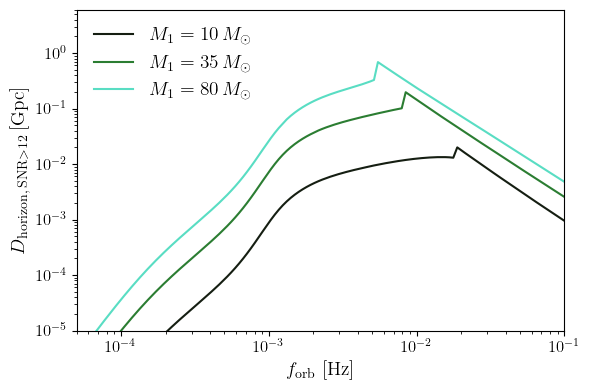

In [121]:
for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    plt.plot(f_LISA, DH[ind, q_ind, ecc_ind, :], color=cs2[ii], label=labels[ii])
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, prop={'size':14})
plt.ylabel(r'$D_{\rm{horizon,\,SNR>12}}\,[\rm{Gpc}]$', size=14)
plt.xlabel(r'$f_{\rm orb}$ [Hz]', size=14)
plt.ylim(1e-5, 6)
plt.tick_params(axis='both', labelsize=12)

plt.xlim(5e-5, 0.1)
plt.tight_layout()

plt.savefig('horizon.png', facecolor='white', dpi=250)

7529.500720577171
21.951897144539856
4.357349954037716


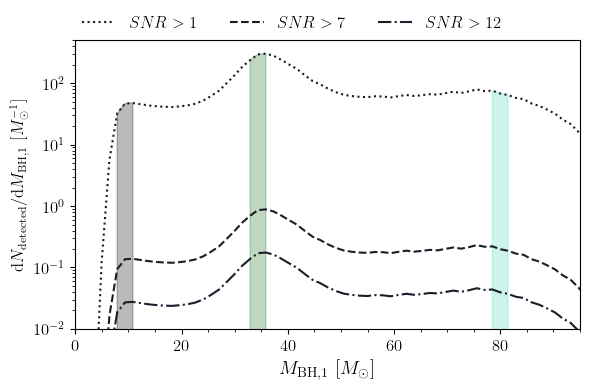

In [130]:
fig, ax1 = plt.subplots(1, 1)
#ax1.plot(mass_1.value, dn_dm1.value, ls='-', color='black')

#ax1.set_yscale('log')
#ax1.set_ylim(1e5, 5e10)
ax1.minorticks_on()
#ax1.set_ylabel(r'$\mathrm{d}N_{\rm{intrinsic}} / \mathrm{d}M_{\mathrm{BH,1}}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}$]', size=14)
ax1.set_xlabel(r'$M_{\mathrm{BH,1}}$ [$M_{\odot}$]', size=14)

#ax4 = ax1.twinx()

# Plot data on the second y-axis
color = 'navy'
ax1.set_ylabel(r'$\mathrm{d}N_{\rm{detected}} / \mathrm{d}M_{\mathrm{BH,1}}$ $[M_{\odot}^{-1}$]')
ls_list = [':', '--', '-.']
for ii, dNdm1 in enumerate(dN_dm1_list):
    ax1.plot(mass_1, dNdm1, color=cs[ii], label=labels_snr[ii], ls=ls_list[ii])
    print(trapezoid(dNdm1, mass_1))
    if ii == 0:
        ax1.fill_between(mass_1.value[4:7], np.ones(len(mass_1.value[4:7]))*1e-7, dNdm1.value[4:7], color=cs2[0], alpha=0.3)#, label='$M_{\mathrm{BH,1}}$=10\,$M_{\odot}$')
        ax1.fill_between(mass_1.value[21:24], np.ones(len(mass_1.value[21:24]))*1e-7, dNdm1.value[21:24], color=cs2[1], alpha=0.3)#, label='$M_{\mathrm{BH,1}}$=35\,$M_{\odot}$')
        ax1.fill_between(mass_1.value[52:55], np.ones(len(mass_1.value[52:55]))*1e-7, dNdm1.value[52:55], color=cs2[2], alpha=0.3)#, label='$M_{\mathrm{BH,1}}$=80\,$M_{\odot}$')

ax1.set_ylim(1e-2, 500)
ax1.set_xlim(0, 95)
ax1.set_yscale('log')
ax1.legend(loc=(0, 1.01), frameon=False, ncol=3)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='both', labelsize=12)
fig.tight_layout()
plt.savefig('total_number.png', facecolor='white', dpi=300)